## consider the d dimensional model

In [3]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from numpy.linalg import inv
import time

EXP_TIMES = 500
TIME_LEVELS = 20
SAMPLE_AMOUNT = 1000

collection1 = np.zeros(EXP_TIMES)
collection2 = np.zeros(EXP_TIMES)

start_time = time.time()
batch = 0

for exp in range(EXP_TIMES):
    # generate
    X1 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    X2 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    # X3 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    # X_2and3 = np.column_stack((X2, X3))
    
    EPSI1 = np.random.uniform(0,1,SAMPLE_AMOUNT)
    EPSI2 = np.random.uniform(0,1,SAMPLE_AMOUNT)
    
    Y1 = X1 + 2 + EPSI1 - EPSI2
    Y2 = X1 + 3 + EPSI1 + EPSI2
    
    # phi(x) = x^2
    A = 4/45
    
    Q = 1/3
    # Q = 1/SAMPLE_AMOUNT * np.matmul(X_2and3.T,X_2and3)
    
    
    dual_density = np.zeros((TIME_LEVELS, TIME_LEVELS, SAMPLE_AMOUNT))
    
    
    m = Model()
    
    pi = [[[m.add_var(lb=0,name="pi") for i in range(SAMPLE_AMOUNT)] for t2 in range(TIME_LEVELS)] for t2 in range(TIME_LEVELS)]
    
    for t1 in range(TIME_LEVELS):
        for t2 in range(TIME_LEVELS):
            
            m += xsum(pi[t1][t2][i] for i in range(SAMPLE_AMOUNT)) == SAMPLE_AMOUNT/TIME_LEVELS**2
            m += xsum(pi[t1][t2][i]*X1[i] for i in range(SAMPLE_AMOUNT)) == xsum(X1[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS**2
        
    for i in range(SAMPLE_AMOUNT):
        m += xsum(xsum(pi[t1][t2][i] for t1 in range(TIME_LEVELS)) for t2 in range(TIME_LEVELS)) == 1
        
    m.objective = maximize(
        xsum(
            xsum(
                xsum(
                    (t1/TIME_LEVELS * Y1[i] + t2/TIME_LEVELS * Y2[i] * pi[t1-1][t2-1][i]) for i in range(SAMPLE_AMOUNT)
                ) for t2 in range(1,TIME_LEVELS+1)
            )for t1 in range(1,TIME_LEVELS+1)
        )
    )
    
    status = m.optimize(max_seconds=600)
    
    if not status == OptimizationStatus.OPTIMAL:
        print("SOMETHING WRONG!")
        break

    else:
        t1=0
        t2=0
        i=0
        for v in m.vars: 
            dual_density[t1][t2][i] = v.x
            i+=1
            if i == SAMPLE_AMOUNT:
                i=0
                t2+=1
            if t2 == TIME_LEVELS:
                t2=0
                t1+=1
    
    # calculate target statistics
    
    b1=0
    b2=0
    for t1 in range(1,TIME_LEVELS+1):
        for t2 in range(1,TIME_LEVELS+1):
            b1 +=  (t1/TIME_LEVELS)**2 * (dual_density[t1-1][t2-1])
            b2 +=  (t2/TIME_LEVELS)**2 * (dual_density[t1-1][t2-1])
        
        
    # S = 1/np.sqrt(SAMPLE_AMOUNT) * np.matmul(X_2and3.T,b)
    S1 = 1/np.sqrt(SAMPLE_AMOUNT) * np.dot(X2,b1)
    S2 = 1/np.sqrt(SAMPLE_AMOUNT) * np.dot(X2,b2)
    
    T_STAT1 = S1**2/(A*Q)
    T_STAT2 = S2**2/(A*Q)
    
    collection1[exp] = T_STAT1
    collection2[exp] = T_STAT2
    
    batch += 1
    
   
    if batch == 10:
        print(time.time()-start_time)
        print("experiment ",exp)
        batch = 0


682.1703307628632
experiment  9
1321.2614924907684
experiment  19
1968.0938708782196
experiment  29
2660.497265815735
experiment  39
3333.0032024383545
experiment  49
4100.314264059067
experiment  59
4829.337055921555
experiment  69
5589.068910598755
experiment  79
6284.506317138672
experiment  89
7002.029573917389
experiment  99
7595.466784000397
experiment  109
8306.012923717499
experiment  119
8924.737991571426
experiment  129
9670.87311911583
experiment  139
10394.994026899338
experiment  149
11114.652570009232
experiment  159
11756.028545856476
experiment  169
12400.739573001862
experiment  179
13122.323748350143
experiment  189
13833.514174222946
experiment  199
14517.8935983181
experiment  209
15188.299668312073
experiment  219
15864.058164358139
experiment  229
16598.93606185913
experiment  239
17359.29555082321
experiment  249
17984.664137601852
experiment  259
18607.388886213303
experiment  269
19286.68488097191
experiment  279
20013.191232681274
experiment  289
20670.0707650

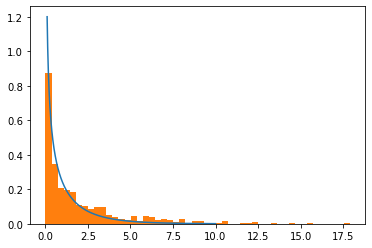

In [5]:
from scipy.stats import chi2

#x-axis ranges from 0 to 20 with .001 steps
x = np.arange(0.1, 10, 0.001)

#plot Chi-square distribution with 1 degrees of freedom
plt.plot(x, chi2.pdf(x, df=1))

plt.hist(collection1, density=True, bins=50)

plt.show()

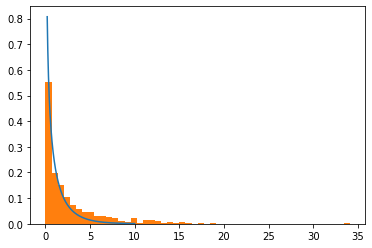

In [7]:
from scipy.stats import chi2

#x-axis ranges from 0 to 20 with .001 steps
x = np.arange(0.2, 10, 0.001)

#plot Chi-square distribution with 1 degrees of freedom
plt.plot(x, chi2.pdf(x, df=1))

plt.hist(collection2, density=True, bins=50)

plt.show()

## Pretty result! indicating that our guess is quite likely right